<center><font size = "10"> Week 9 - STDP<center>
<center><font size = "8">Tutorial 2: Clopath et al. 2010<center>

<font color='blue'><font size=3> In this tutorial you will:
    
<font color='blue'><font size=3>- use a the model of voltage-dependent plasticity developed by Claudia Clopath and colleagues
    
<font color='blue'><font size=3>- see how this model reproduces STDP$ 


<font size="5">

We are going to work with a model proposed in 2010:  https://www.nature.com/articles/nn.2479

The Clopath et al. model allows us to explore how plasticity can be affected by biophysics. Ion channel distributions and neuronal morphology will affect the changes in membrane potential at a synapse and thereby modulate plasticity. 

We will use a ball-and-stick model: a simplified neuron in which one section represents the soma and basal dendrites while a narrower, longer one represents the apical dendrites.



<font size="5">
The clopath model updates the maximum conductance of the neuron with the following formula:

$ \frac{d \bar{g}}{dt} = A_{+}rec(u_{+}(t) - \theta_{-} ) \bar{x}(t) - A_{-} rec(u_{-}(t) - \theta_{-}) X(t) $

where $rec$ represents rectification `rec(x) = x if x > 0 else 0` , $X(t)$ is a sum of dirac-delta functions situated at the presynaptic spiketimes (so that the integral where there is a spike equals 1, and elsewhere it equals 0). $\bar{x}$ is a trace left behind by the presynaptic AP which decays exponentially, and $u_{-}$ and $u_{+}$ are low-pass filtered versions of the membrane potential. The rest are parameters.

This should make much more sense once you've seen it in action.

<font color='red'> we have the modfile as it is available on modeldb, but there is a bug in its implementation: its behavior will change if you change the step size of the simulation. I have not fixed this so when playing with the model just keep the step size at the default.

In [1]:
!nrnivmodl

/home/NX450-2023/Preparation/week_9
Mod files: "./VecStim.mod" "./stdp_cc.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [2]:
# First call all the useful packages
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

--No graphics will be displayed.


In [3]:
DG = '$\Delta \\bar{g} $(% initial)'
FREQUENCY = 'frequency (Hz)'
DT = '$\Delta t (ms)$'

<font size="5">

## Ball and stick neuron

We'll use a simplified neuron with two sections representing the soma and the apical dendrite.

In [4]:
h.load_file("stdrun.hoc")
def ball_and_stick():
    soma = h.Section(name='soma')
    soma.diam = 20
    soma.L = 20
    apical = h.Section(name='apical')
    apical.diam = 10
    apical.L = 40
    apical.nseg=21
    apical.connect(soma(1))

    apical.insert('pas')
    soma.insert('hh')
    soma.insert('pas')
    for seg in soma:
        seg.hh.el =-70
        
    return soma, apical


soma, apical = ball_and_stick()
h.topology()


|-|       soma(0-1)
   `--------------------|       apical(0-1)



1.0

## Clopath synapse model

In [5]:
def ccsynapse(segment):
    syn = h.STDPSynCC(segment)
    # depression threshold should be same as resting potential to reproduce LTD
    syn.tetam = segment.pas.e
    syn.tau_0 = 6
    syn.tau_y = 5
    syn.A_m = 14e-5
    syn.A_p = 8e-5
    syn.gbar=0.05
    return syn
synapse_soma = ccsynapse(soma(0.5))


<font size="5">

## Stimulation protocol

We can investigate how this model leads to STDP by stimulating the synapse and the soma at specific times.
This is to mimic experimental procedures like this one : https://pubmed.ncbi.nlm.nih.gov/8985014/



In [12]:
def STDP_simulation(
    soma,
    synapse,
    frequency=10, # Hz
    spike_offset=5, # ms
    interstimulus_interval=500, # ms
    nrepetitions=10,
    spikes_per_repetition=5,
    stim_amplitude=1, # nA
    stim_dur=1, # ms
    plot=True,
    view_closely=False
):
    """
    Simulate a STDP protocol with the provided soma and synapse.
    
    Run a protocol in which the synapse and soma are stimulated within a set window of each other.
    Plot a timeseries of the protocol and return the percent change in synaptic conductance.
    
    Arguments:
       soma: neuron section to treat as the soma.
       synapse: synapse object to stimulate.
       frequency: frequency of pre-post spike pairs during each repetition (in Hz).
       interstimulus_interval: interval between stimulation repetitions in ms.
       nrepetitions: number of repetitions of the protocol.
       spikes_per_repeition: number of pre and post spike pairs in each repeition.
       stim_amplitude: current for postsynaptic stimulus in nA.
       stim_dur: duration of postsynaptic stimulus in ms. 
           Current and duration should be sufficient to cause AP firing
       plot: whether or not to plot timeseries (default True)
       view_closely: whether to zoom in on the first spike for the plot
    """
    pre_stim_list = []
    post_stim = []
    t = 0
    for repetition in range(nrepetitions):
        t += interstimulus_interval
        for spike in range(spikes_per_repetition):
            pre_stim_list.append(t)
            post = h.IClamp(soma(0.5))
            post.delay = t + spike_offset
            post.amp = stim_amplitude
            post.dur = stim_dur
            post_stim.append(post)
            t += 1000 / frequency
            

    pre_stim = h.VecStim()
    t_stim_vec = h.Vector(pre_stim_list)
    pre_stim.play(t_stim_vec, None)
    connection = h.NetCon(pre_stim, synapse)
    connection.delay = 0
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    rec_g = h.Vector()
    rec_g.record(synapse._ref_g)
    rec_gbar = h.Vector()
    rec_gbar.record(synapse._ref_gbar)
    rec_i = h.Vector()
    rec_i.record(synapse._ref_i)
    rec_r = h.Vector()
    rec_r.record(synapse._ref_r)
    
    rec_um1 = h.Vector()
    rec_um1.record(synapse._ref_u_m1)
    rec_um2 = h.Vector()
    rec_um2.record(synapse._ref_u_m2)
    
    h.finitialize(-70)
    h.continuerun(t)
    
    
    time = np.array(rec_t)
    potential = np.array(rec_v)
    conductance = np.array(rec_g)
    current = np.array(rec_i)
    gbar = np.array(rec_gbar)
    spike_trace = np.array(rec_r)

    if plot:
        f, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
        axes[0].plot(time, potential, label='$V_m$')
        axes[0].vlines(np.array(pre_stim_list) + connection.delay, ymin=-70, ymax=20, color='k', label='pre_spikes')
        axes[0].hlines(synapse.tetam, label='$\\theta_{-}$', color='gray', xmin=time.min(), xmax=time.max())
        axes[0].hlines(synapse.tetap, label='$\\theta_{+}$', color='gray', xmin=time.min(), xmax=time.max())

        axes[0].vlines([post.delay for post in post_stim], ymin=-70, ymax=20, color='cyan', label='post_stims')

        axes[0].plot(time, rec_um1, label='$u_{-}$')
        axes[0].plot(time, rec_um2, label='$u_{+}$')
        
        def scale_secondary(values):
            return (values + 75) / 125
        
        def unscale_secondary(values):
            return (values * (125 / spike_trace.max())) - 75
            
        secax = axes[0].secondary_yaxis('right', functions=(scale_secondary, unscale_secondary))
        secax.set_ylabel('x (unitless)')

        axes[0].plot(time, unscale_secondary(spike_trace), label='$\\bar{x}$')
        

        if view_closely:
            plt.xlim(interstimulus_interval-25, interstimulus_interval+25)
        axes[0].set_ylabel('voltage (mV)')
        axes[1].set_xlabel('t (ms)')
        #axes[1].set_ylabel('$I_{syn} (nA)$')
        axes[1].set_ylabel('conductance (nS)')
        
        #axes[1].plot(time, current)
        axes[1].plot(time, conductance, label='$g_{syn}$')
        axes[1].plot(time, gbar, label='$\\bar{g}$')
        axes[1].set_ylim(conductance.min(), gbar.max() + 0.0001)
        axes[1].legend()
        #plt.title(f'frequency={frequency} Hz')
        plt.title(f'f={frequency} Hz, $\Delta_t$={spike_offset} ms') 
        axes[0].legend()

    return (gbar[-1] - gbar[0]) / gbar[0]
    

## LTP
In the trace below we have visualized several of the variables that the model uses to calculate the dynamics. There is a region (around 507-510 ms) where $\bar{x}$ (r in the modfile) is nonzero, membrane potential is above $\theta_{+}$, and the filtered version of membrane potential $u_{+}$ is higher than $\theta_{-}$. These are the conditions under which long-term potentiation can take place in the clopath model. Indeed, we see a slight change in the value of $\bar{g}$





0.1831438579100952

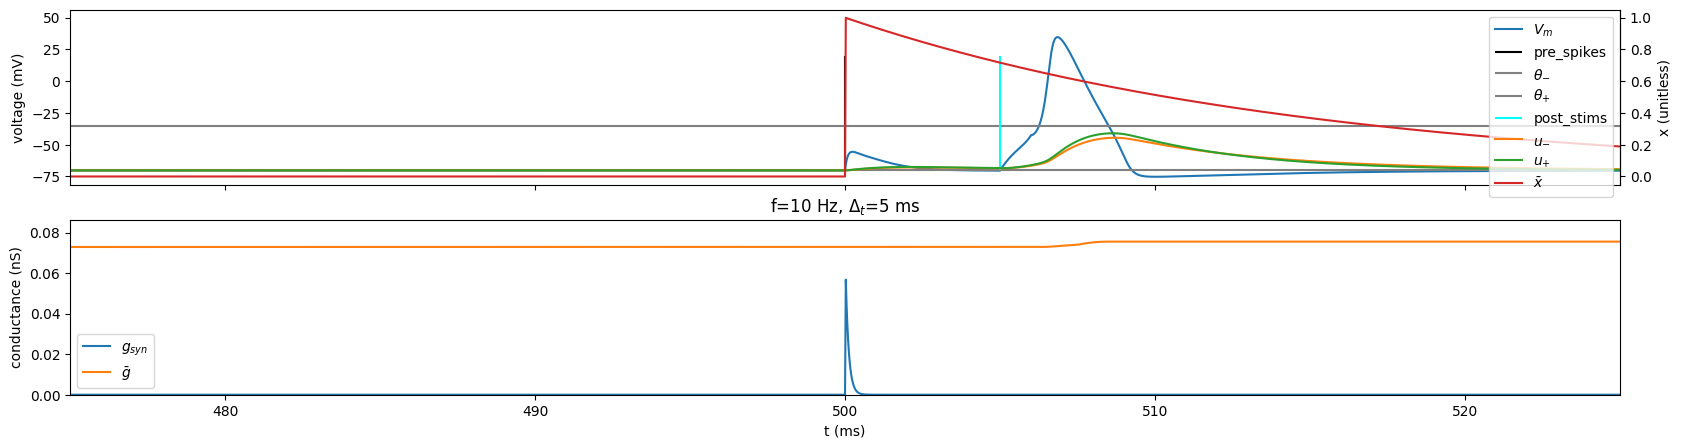

In [13]:
STDP_simulation(soma, synapse_soma, view_closely=True, nrepetitions=1)

# LTD

In the trace below, we can see that when the spike arrives the filtered version of the membrane potential $u_{-}$ is above the threshold $\theta_{+}$, leading to Long-term depression of the synapse. Unlike LTP, LTD in the clopath model is instantaneous.

-0.27930517013516304

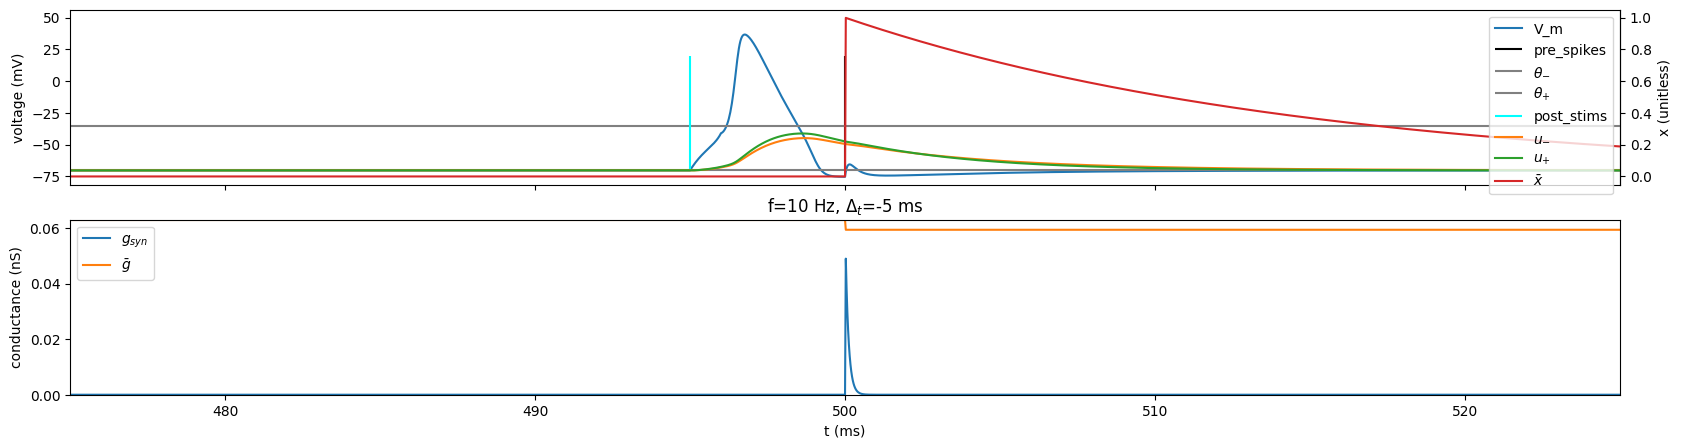

In [8]:
STDP_simulation(soma, synapse_soma, view_closely=True, nrepetitions=1, spike_offset=-5)

# STDP

By varying the timing of the spikes, we can get a spike-timing curve.
If you increase the number of repetitions or spikes per repetition, you may see a weight change of -100% : meaning a negative conductance.
Just remember that this is absolutely bonkers and has no basis in biology: glutamatergic synapses do not reverse their polarity.
It may be a fun exercise to consider how you would address this when using the clopath model in a network of your own. Remove the synapse and place a new one whenever it drops below 0? apply an additional term dampening it to an intermediate value?

You may also note that with the parameters reported in the paper our model changes much more rapidly than is seen in experiments.
It is important to consider that with biophysically grounded plasticity models a lot relies on the biophysics of the cell model as well. If the shape of the action potential changes by e.g. increasing potassium conductance that will affect the form of the plasticity as well.

100%|██████████| 11/11 [00:31<00:00,  2.88s/it]
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


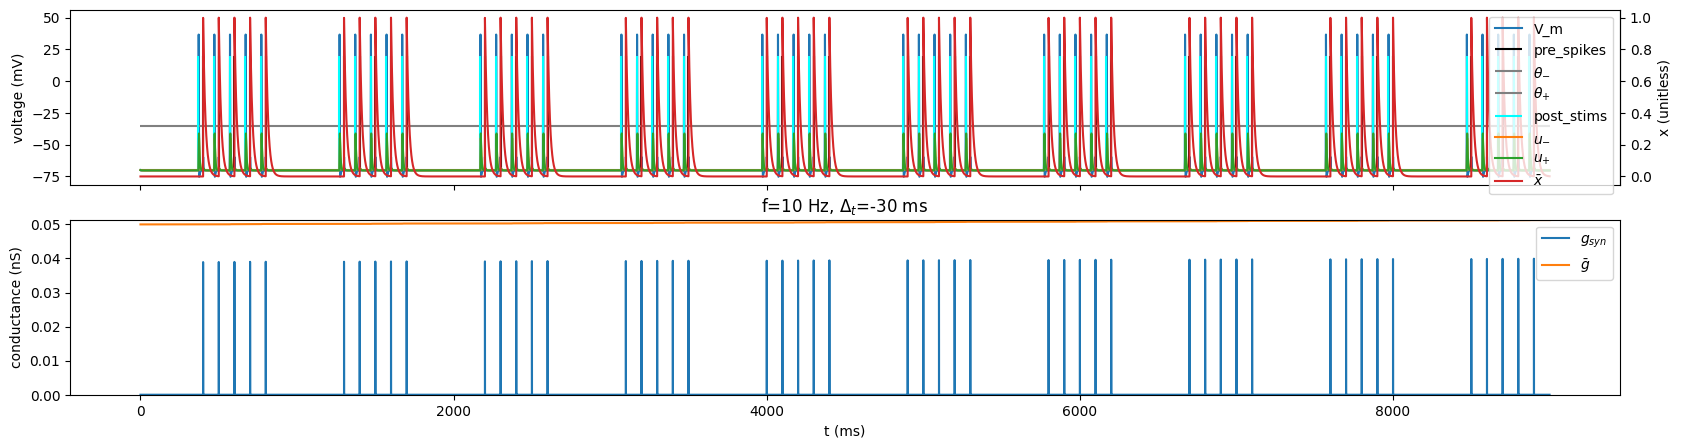

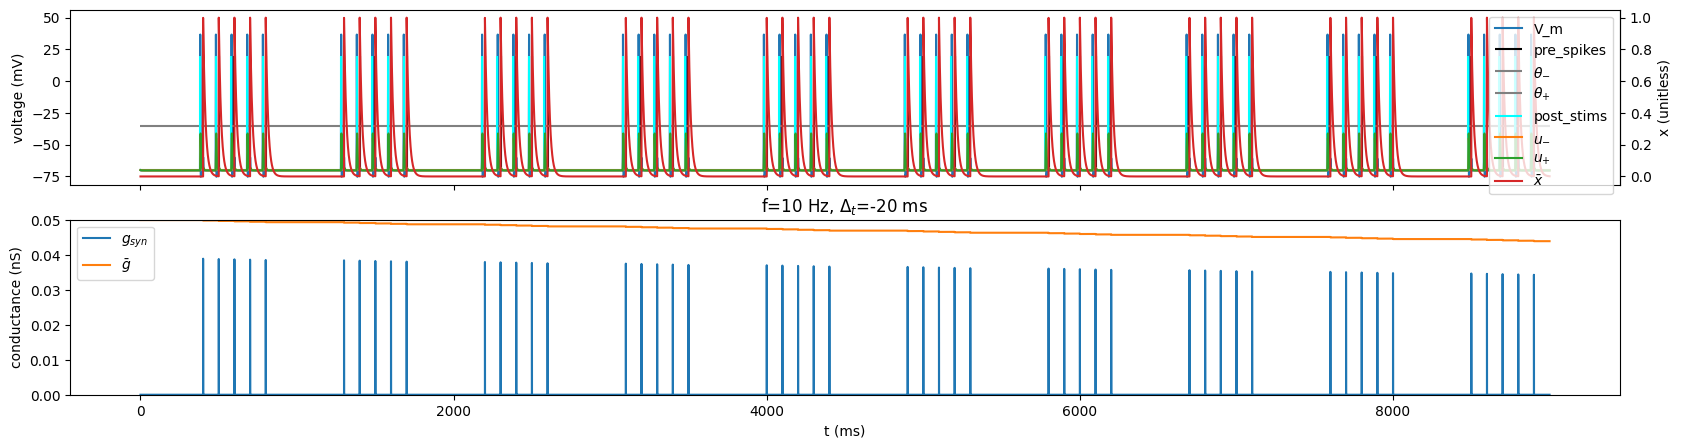

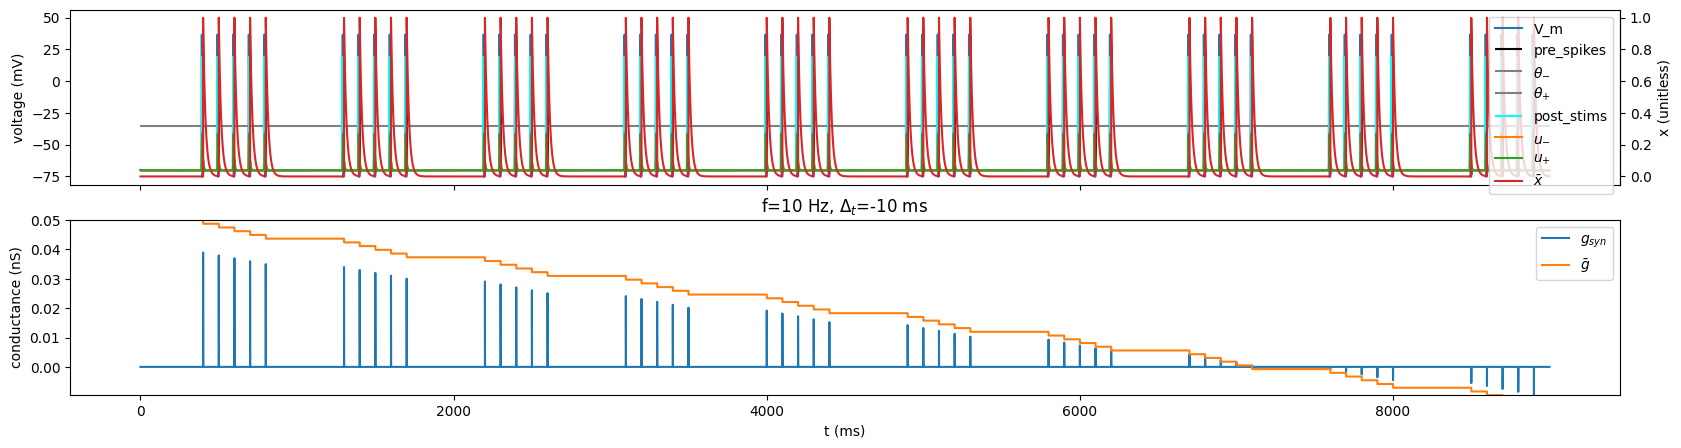

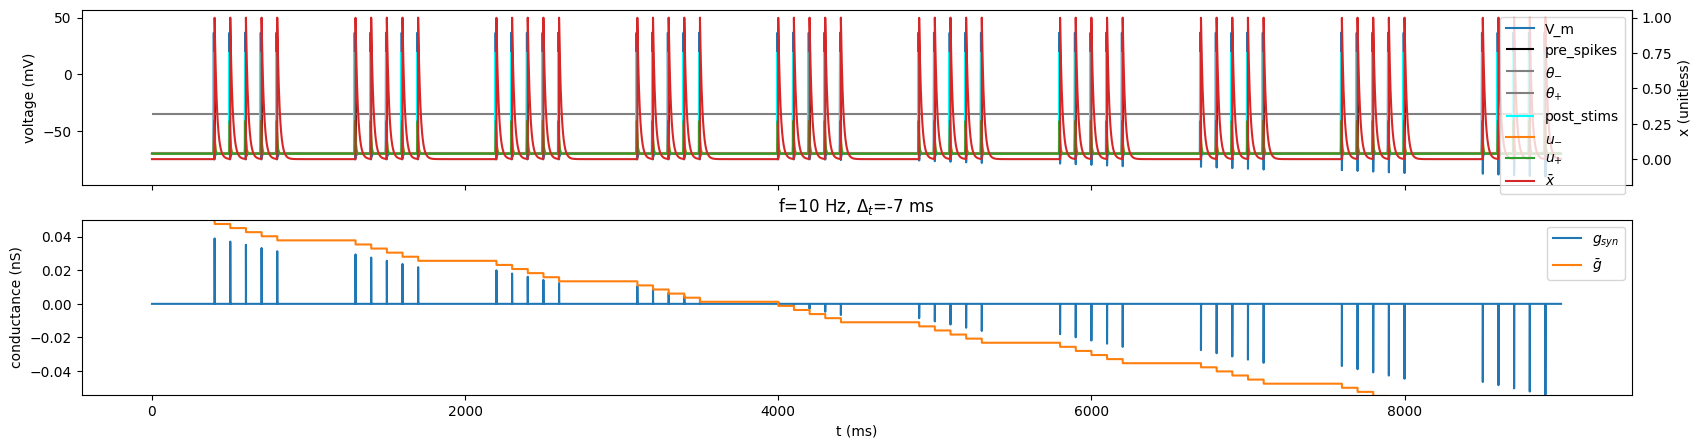

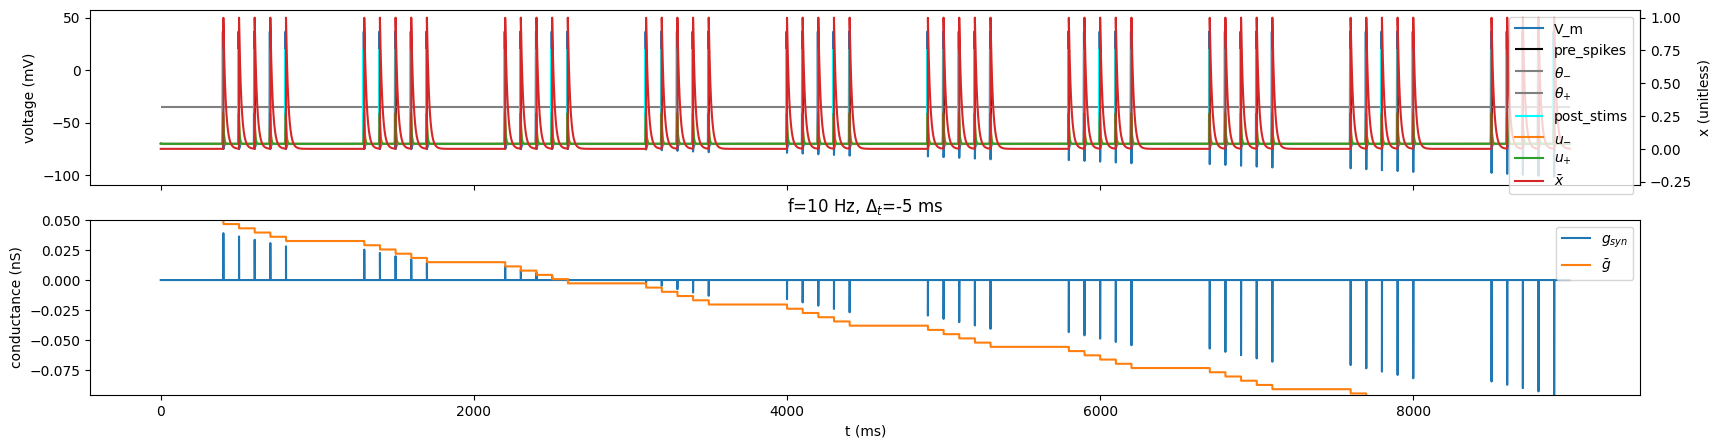

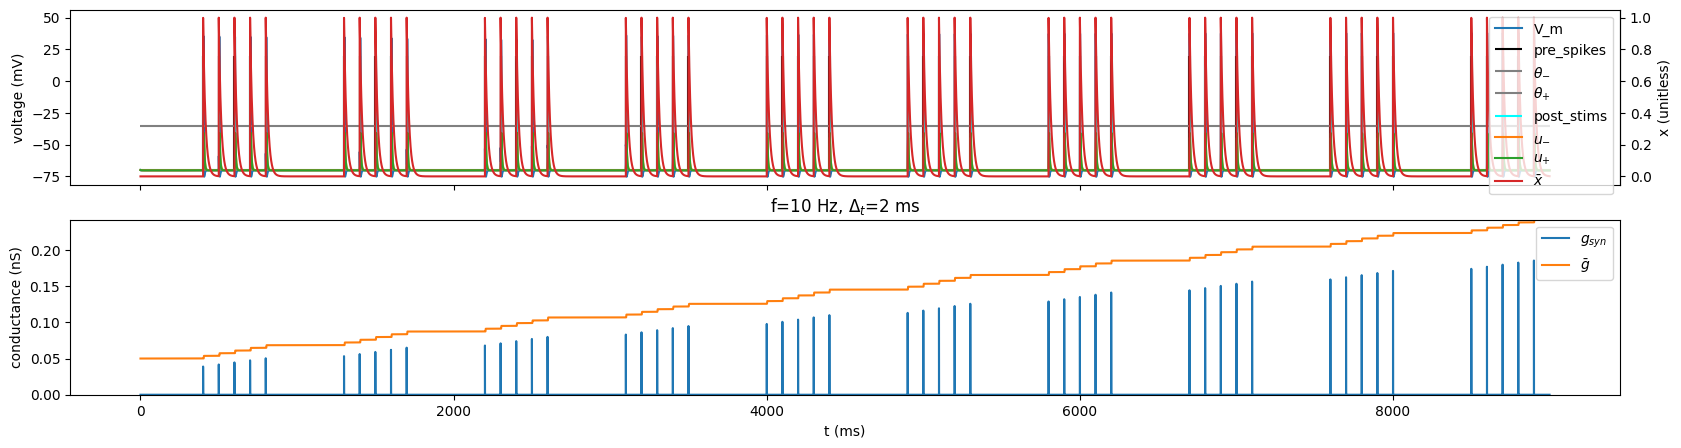

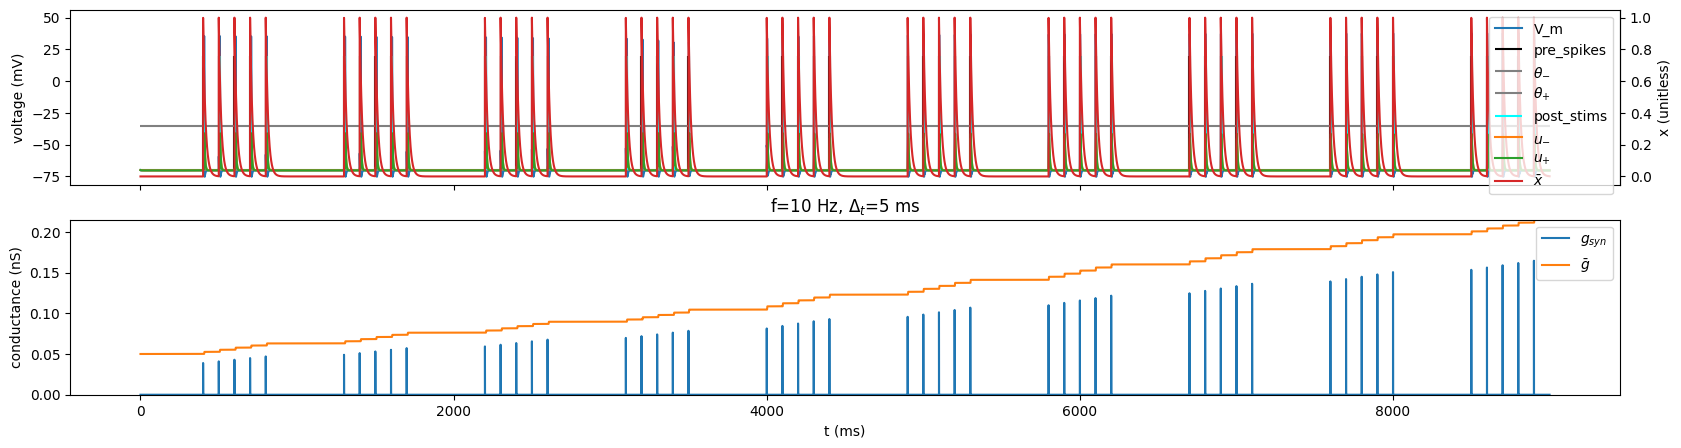

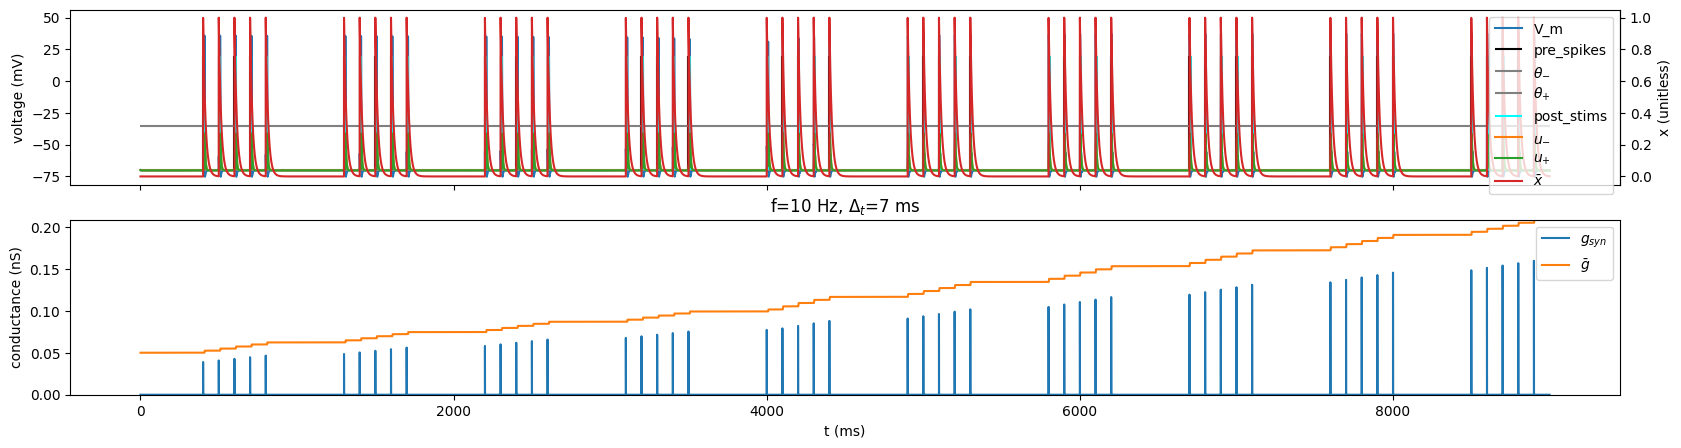

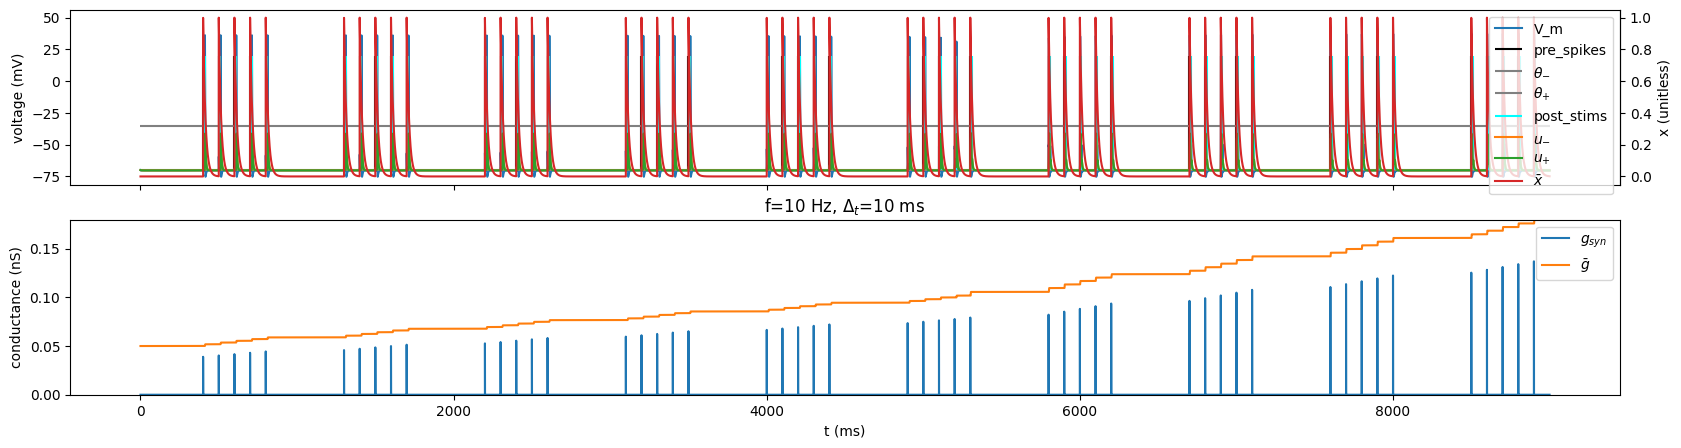

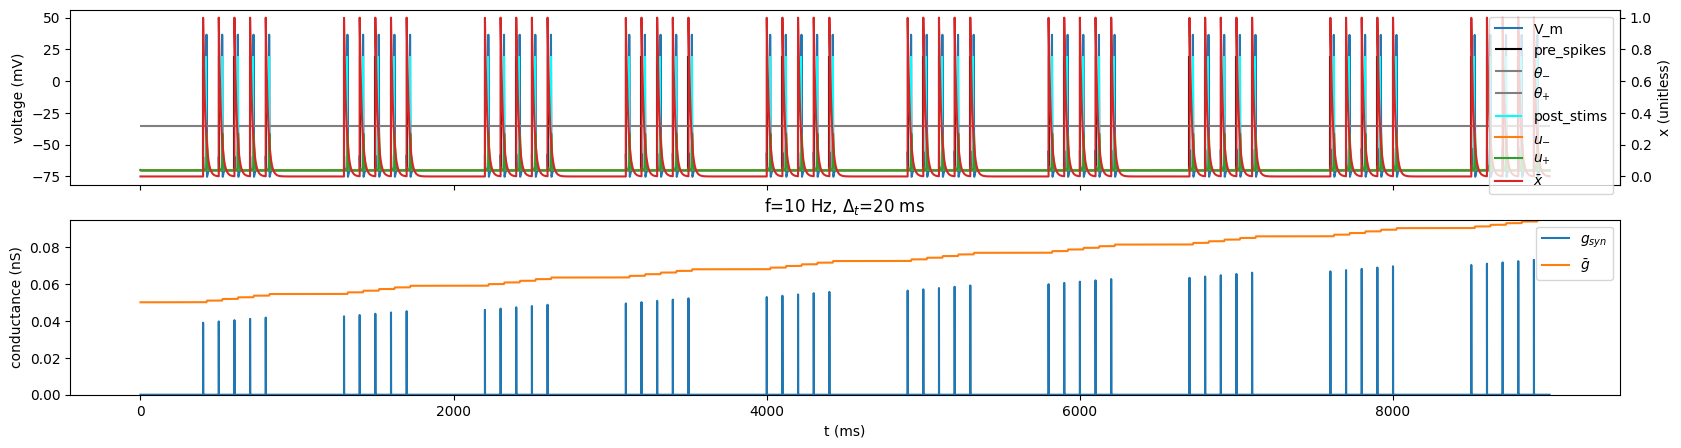

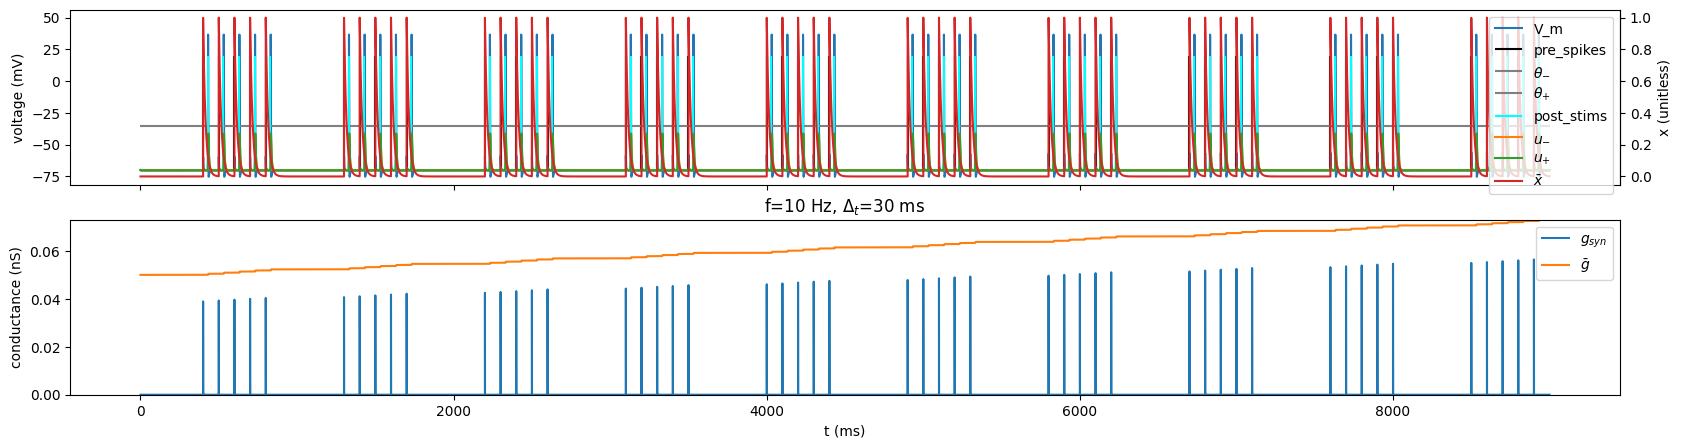

In [9]:

data = []
frequency = 10 # Hz
spike_offset = 5
for spike_offset in tqdm([-30, -20, -10, -7, -5, 2, 5, 7, 10, 20, 30]):
    del soma, apical, synapse_soma
    soma, apical = ball_and_stick()
    synapse_soma = ccsynapse(soma(0.5))

    dgbar = STDP_simulation(
        soma, synapse_soma, frequency=frequency, spike_offset=spike_offset,
        nrepetitions=10, spikes_per_repetition=5, interstimulus_interval=400)

    data.append({
        DG: dgbar * 100,
        FREQUENCY: frequency,
        DT: spike_offset})
    
    
data = pd.DataFrame(data)

In [10]:
data

,$\Delta \bar{g} $(% initial),frequency (Hz),$\Delta t (ms)$
0,2.550629,10,-30
1,-12.084035,10,-20
2,-126.880216,10,-10
3,-243.880569,10,-7
4,-351.690046,10,-5
5,383.241907,10,2
6,329.402939,10,5
7,316.577125,10,7
8,259.172510,10,10
9,89.121994,10,20


Text(0.5, 0, '$\\Delta t (ms)$')

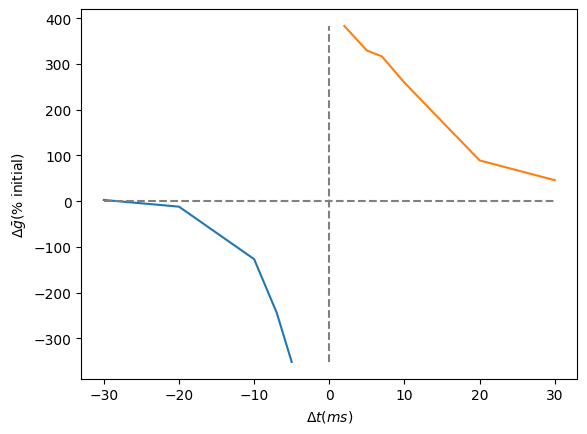

In [11]:
neg = data[DT] < 0
plt.plot(data[DT][neg], data[DG][neg])
plt.plot(data[DT][~neg], data[DG][~neg])
plt.vlines([0], ymin=data[DG].min(), ymax=data[DG].max(), linestyle='--', color='gray')
plt.hlines([0], xmin=data[DT].min(), xmax=data[DT].max(), linestyle='--', color='gray')
plt.ylabel(DG)
plt.xlabel(DT)

If you are still confused by the model, refer to the supplementary materials of the paper for a mathermatical breakdown.